In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-1-6133029a2d5b>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

## 1. The Transformer architecture

In the first part of this notebook, we will implement the Transformer architecture by hand. As the architecture is so popular, there already exists a Pytorch module `nn.Transformer` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) and a [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on how to use it for next token prediction. However, we will implement it here ourselves, to get through to the smallest details.

### Scaled Dot Product Attention

In [2]:
def scaled_dot_product(q, k, v, mask=None):
    """
    Implements scaled dot-product attention.

    Args:
        q: Query vectors (shape: batch_size, num_heads, seq_len, d_k).
        k: Key vectors (shape: batch_size, num_heads, seq_len, d_k).
        v: Value vectors (shape: batch_size, num_heads, seq_len, d_v).
        mask: Optional mask to prevent attention weights on padding tokens (shape: batch_size, 1, 1, seq_len).

    Returns:
        values: Weighted sum of value vectors (shape: batch_size, num_heads, seq_len, d_v).
        attention: Attention weights (shape: batch_size, num_heads, seq_len, seq_len).
    """

    # Dimension of the key vector (d_k)
    d_k = q.size()[-1]

    # Calculate attention logits (scores) using matrix multiplication
    attn_logits = torch.matmul(q, k.transpose(-2, -1))

    # Scale the logits by dividing by the square root of d_k
    attn_logits = attn_logits / math.sqrt(d_k)

    # Apply masking if provided
    if mask is not None:
        # Set masked elements in attn_logits to a very negative value (-9e15)
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)

    # Compute attention weights using softmax along the last dimension
    attention = F.softmax(attn_logits, dim=-1)

    # Weight the value vectors using the attention weights
    values = torch.matmul(attention, v)

    # Return the weighted values and attention weights
    return values, attention


Note that our code above supports any additional dimensionality in front of the sequence length so that we can also use it for batches. However, for a better understanding, let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:

INFO:lightning_fabric.utilities.seed:Seed set to 42


Q (Query Vectors):
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K (Key Vectors):
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V (Value Vectors):
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values (Weighted Sum of V):
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention Weights:


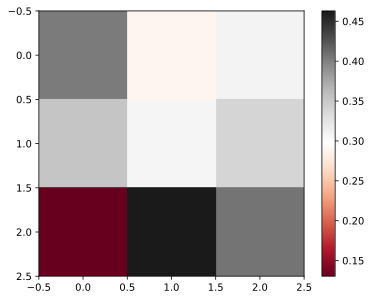

In [3]:
# Set random seed for reproducibility
pl.seed_everything(42)  # Assuming you meant `plt.seed_everything`

# Define sequence length and key/value vector dimension
seq_len, d_k = 3, 2

# Generate random query, key, and value vectors
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

# Perform scaled dot-product attention
values, attention = scaled_dot_product(q, k, v)

# Print the tensors
print("Q (Query Vectors):\n", q)
print("K (Key Vectors):\n", k)
print("V (Value Vectors):\n", v)
print("Values (Weighted Sum of V):\n", values)

# Optional visualization of attention weights (requires matplotlib)
print("Attention Weights:")
plt.imshow(attention.detach().cpu().numpy(), cmap="RdGy")  # Detach and move to CPU for visualization
plt.colorbar()
plt.show()

### Multi-Head Attention

In [4]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

### Transformer Encoder

In [5]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [6]:
class TransformerEncoder(nn.Module):
    """
    Transformer encoder class that stacks multiple EncoderBlock instances.

    Args:
        num_layers (int): Number of encoder layers to be stacked.
        **block_args (dict): Keyword arguments to be passed to the EncoderBlock constructor.
    """

    def __init__(self, num_layers, **block_args):
        super().__init__()
        """
        Initializes the TransformerEncoder module.

        - Creates a ModuleList named 'layers' to hold the stacked EncoderBlocks.
        - Iterates 'num_layers' times, creating an EncoderBlock instance with
          the provided 'block_args' for each layer and adding it to the 'layers' list.
        """
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        """
        Performs the forward pass through the stacked encoder layers.

        Args:
            x (tensor): Input sequence to be processed by the encoder.
            mask (tensor, optional): Masking tensor to prevent attention to padding tokens.

        Returns:
            tensor: Final output after processing through all encoder layers.
        """
        for l in self.layers:
            x = l(x, mask=mask)  # Pass input through current encoder layer
        return x

    def get_attention_maps(self, x, mask=None):
        """
        Retrieves attention maps from the self-attention mechanism in each encoder layer.

        Args:
            x (tensor): Input sequence to be processed by the encoder.
            mask (tensor, optional): Masking tensor to prevent attention to padding tokens.

        Returns:
            list: List of attention maps generated by each encoder layer.
        """
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            # Extract attention map and append to list
            attention_maps.append(attn_map)
            x = l(x)  # Pass input through current encoder layer
        return attention_maps


### Learning rate warm-up

In [7]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    """
    Custom learning rate scheduler that combines cosine annealing with warmup.

    Args:
        optimizer (torch.optim.Optimizer): The optimizer whose learning rate will be scheduled.
        warmup (int): Number of epochs to linearly increase the learning rate.
        max_iters (int): Total number of training iterations (epochs).
    """

    def __init__(self, optimizer, warmup, max_iters):
        """
        Initializes the CosineWarmupScheduler instance.

        - Stores the optimizer, warmup duration, and maximum training iterations.
        - Calls the superclass constructor to initialize the base learning rate scheduler.
        """
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        """
        Calculates the learning rates for all param groups in the optimizer.

        - Calls the get_lr_factor method to compute a learning rate factor based on the current epoch.
        - Multiplies the base learning rates in each param group by the learning rate factor to get the final learning rates.
        - Returns a list containing the adjusted learning rates for all param groups.
        """
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        """
        Computes the learning rate factor based on the current epoch.

        - Implements a cosine annealing schedule with a warmup phase.
        - Calculates a learning rate factor using a cosine function with period equal to the total training iterations.
        - During the warmup phase (<= warmup epochs), linearly increases the learning rate factor from 0 to 1.
        - Returns the learning rate factor used to adjust the base learning rates.
        """
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor


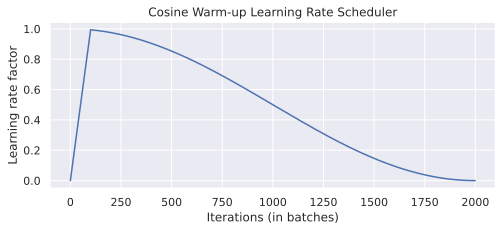

In [8]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

### PyTorch Lightning Module

In [9]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, seq_len, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.seq_len=seq_len
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, self.seq_len,self.hparams.model_dim))

        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = x+self.positional_encoding
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = x+self.positional_encoding
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

## 2. Experiments

### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input _and_ the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well.

First, let's create a dataset class below.

In [10]:
class ReverseDataset(data.Dataset):
    """
    Custom dataset class that generates sequences with reversed labels.

    Args:
        num_categories (int): Number of possible categories for each element in the sequence.
        seq_len (int): Length of the sequence generated for each sample.
        size (int): Total number of samples to be generated in the dataset.
    """

    def __init__(self, num_categories, seq_len, size):
        """
        Initializes the ReverseDataset instance.

        - Stores the number of categories, sequence length, and dataset size.
        - Generates random integer sequences using torch.randint with the specified parameters.
        - Flips the generated sequences along the first dimension (0) to create reversed labels.
        """
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.size

    def __getitem__(self, idx):
        """
        Retrieves a specific sample (input and corresponding reversed label) from the dataset.

        Args:
            idx (int): Index of the sample to be retrieved.

        Returns:
            tuple: A tuple containing the input data and its reversed label (as tensors).
        """
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels


We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders below.

In [11]:
# Define sequence length for each sample
seq_len = 16   # sequence length
nCategories = 20  # number of different elements in our sequence (here, numbers between 0 and nCategories-1)

# Create a partial function for ReverseDataset with fixed num_categories and seq_len
dataset = partial(ReverseDataset, num_categories=nCategories, seq_len=seq_len)

# Create data loaders for training, validation, and testing

# Training data loader
train_loader = data.DataLoader(
    dataset(size=50000),  # Create ReverseDataset instance with 50000 samples
    batch_size=128,        # Batch size for training
    shuffle=True,          # Shuffle data for each epoch (training only)
    drop_last=True,         # Drop incomplete batch at the end (training only)
    pin_memory=True         # Attempt to pin tensors to GPU memory (if available)
)

# Validation data loader
val_loader = data.DataLoader(
    dataset(size=1000),   # Create ReverseDataset instance with 1000 samples
    batch_size=128          # Batch size for validation
)

# Testing data loader
test_loader = data.DataLoader(
    dataset(size=10000),  # Create ReverseDataset instance with 10000 samples
    batch_size=128          # Batch size for testing
)


Let's look at an arbitrary sample of the dataset:

In [12]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([19, 16, 12, 10,  6,  2, 17, 19,  7,  3,  3, 14, 13, 17, 10,  9])
Labels:     tensor([ 9, 10, 17, 13, 14,  3,  3,  7, 19, 17,  2,  6, 10, 12, 16, 19])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token. We use the standard Cross-Entropy loss to perform this. Every number is represented as a one-hot vector. Remember that representing the categories as single scalars decreases the expressiveness of the model extremely as $0$ and $1$ are not closer related than $0$ and $9$ in our example. An alternative to a one-hot vector is using a learned embedding vector as it is provided by the PyTorch module `nn.Embedding`. However, using a one-hot vector with an additional linear layer as in our case has the same effect as an embedding layer (`self.input_net` maps one-hot vector to a dense vector, where each row of the weight matrix represents the embedding for a specific category).

To implement the training dynamic, we create a new class inheriting from `TransformerPredictor` and overwriting the training, validation and test step functions.

In [13]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Finally, we create a `pl.Trainer` object, running for $N$ epochs, logging in TensorBoard, and saving our best model based on the validation. Afterward, we test our models on the test set. An additional parameter we pass to the trainer here is `gradient_clip_val`. This clips the norm of the gradients for all parameters before taking an optimizer step and prevents the model from diverging if we obtain very high gradients at, for instance, sharp loss surfaces (see many good blog posts on gradient clipping, like [DeepAI glossary](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)). For Transformers, gradient clipping can help to further stabilize the training during the first few iterations, and also afterward. In plain PyTorch, you can apply gradient clipping via `torch.nn.utils.clip_grad_norm_(...)` (see [documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html#torch.nn.utils.clip_grad_norm_)). The clip value is usually between 0.5 and 10, depending on how harsh you want to clip large gradients. After having explained this, let's implement the training function:

In [14]:
def train_reverse(**kwargs):
    """
    Trains a model for the reverse prediction task.

    Args:
        **kwargs: Additional keyword arguments to be passed to the ReversePredictor model constructor.

    Returns:
        tuple: A tuple containing the trained model and a dictionary with test and validation accuracy results.
    """

    # Create a PyTorch Lightning trainer with configuration
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")  # Directory for model checkpoints
    os.makedirs(root_dir, exist_ok=True)  # Create directory if it doesn't exist

    trainer = pl.Trainer(
        default_root_dir=root_dir,  # Set the root directory for checkpoints
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        # Save only model weights, maximize validation accuracy, monitor validation accuracy
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        # Use GPU if available, otherwise use CPU
        devices=1,  # Train on a single device
        max_epochs=20,  # Maximum number of training epochs
        gradient_clip_val=5,  # Clip gradients to prevent exploding gradients
    )

    # Remove unnecessary logging argument
    trainer.logger._default_hp_metric = None  # Optional hyperparameter logging, disabled here

    # Create the ReversePredictor model with arguments and maximum iterations
    model = ReversePredictor(max_iters=trainer.max_epochs * len(train_loader), **kwargs)
    # Set the maximum iterations based on training epochs and data loader length

    # Train the model on the training data loader and validate on the validation data loader
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the best model on the validation and test sets
    val_result = trainer.test(model, val_loader, verbose=False)  # Test on validation set
    test_result = trainer.test(model, test_loader, verbose=False)  # Test on test set

    # Extract and store test and validation accuracy results
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    # Move the model to the appropriate device (GPU or CPU)
    model = model.to(device)

    # Return the trained model and the results dictionary
    return model, result


Finally, we can train the model. In this setup, we will use a single encoder block and a single head in the Multi-Head Attention. This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers).

In [ ]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              seq_len=seq_len,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 3.2 K 
----------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

The warning of PyTorch Lightning regarding the number of workers can be ignored for now. As the data set is so simple and the `__getitem__` finishes a neglectable time, we don't need subprocesses to provide us the data (in fact, more workers can slow down the training as we have communication overhead among processes/threads). First, let's print the results:

In [ ]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  89.55%
Test accuracy: 89.55%


As we would have expected, the Transformer can correctly solve the task. However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input? Let's try to visualize it below.

In [ ]:
# Get a batch of data and labels from the validation data loader
data_input, labels = next(iter(val_loader))

# One-hot encode the input data
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()

# Move the data to the appropriate device (GPU or CPU)
inp_data = inp_data.to(device)

# Calculate attention maps using the model's get_attention_maps method
attention_maps = reverse_model.get_attention_maps(inp_data)


The object `attention_maps` is a list of length $N$ where $N$ is the number of layers. Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [ ]:
attention_maps[0].shape

torch.Size([128, 1, 150, 150])

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index indicating for which batch element we want to visualize the attention map. We will create a plot where over rows, we have different layers, while over columns, we show the different heads. Remember that the softmax has been applied for each row separately.

In [15]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

Finally, we can plot the attention map of our trained Transformer on the reverse task:

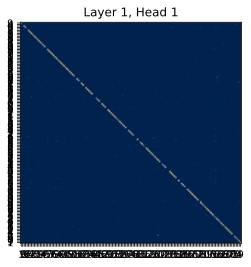

In [ ]:
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself. Hence, it actually does what we intended it to do. We see that it however also pays some attention to values close to the flipped index. This is because the model doesn't need the perfect, hard attention to solve this problem, but is fine with this approximate, noisy attention map. The close-by indices are caused by the similarity of the positional encoding, which we also intended with the positional encoding.

## Plot the validation and test accuracy for difference sequence lengths

In [16]:
seq_lengths = range(100,550,50)
nCategories = 20  # number of different elements in our sequence (here, numbers between 0 and nCategories-1)
val_accs = []
test_accs = []

for seq_len in seq_lengths:

  # Create a partial function for ReverseDataset with fixed num_categories and seq_len
  dataset = partial(ReverseDataset, num_categories=nCategories, seq_len=seq_len)

  # Create data loaders for training, validation, and testing

  # Training data loader
  train_loader = data.DataLoader(
      dataset(size=50000),  # Create ReverseDataset instance with 50000 samples
      batch_size=128,        # Batch size for training
      shuffle=True,          # Shuffle data for each epoch (training only)
      drop_last=True,         # Drop incomplete batch at the end (training only)
      pin_memory=True         # Attempt to pin tensors to GPU memory (if available)
  )

  # Validation data loader
  val_loader = data.DataLoader(
      dataset(size=1000),   # Create ReverseDataset instance with 1000 samples
      batch_size=128          # Batch size for validation
  )

  # Testing data loader
  test_loader = data.DataLoader(
      dataset(size=10000),  # Create ReverseDataset instance with 10000 samples
      batch_size=128          # Batch size for testing
  )


  reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              seq_len=seq_len,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

  val_accs.append(round(100.0 * reverse_result['val_acc'],2))
  test_accs.append(round(100.0 * reverse_result['test_acc'],2))



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 3.2 K 
----------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 4.8 K 
----------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 6.4 K 
----------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 8.0 K 
----------------------------------------------------
19.0 K    Trainable params
0         Non-trainable params
19.0 K    Total params
0.076     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 9.6 K 
----------------------------------------------------
20.6 K    Trainable params
0         Non-trainable params
20.6 K    Total params
0.082     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 11.2 K
----------------------------------------------------
22.2 K    Trainable params
0         Non-trainable params
22.2 K    Total params
0.089     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 12.8 K
----------------------------------------------------
23.8 K    Trainable params
0         Non-trainable params
23.8 K    Total params
0.095     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 14.4 K
----------------------------------------------------
25.4 K    Trainable params
0         Non-trainable params
25.4 K    Total params
0.102     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | input_net    | Sequential         | 672   
1 | transformer  | TransformerEncoder | 8.5 K 
2 | output_net   | Sequential         | 1.8 K 
  | other params | n/a                | 16.0 K
----------------------------------------------------
27.0 K    Trainable params
0         Non-trainable params
27.0 K    Total params
0.108     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [17]:
print(f"Val accs {nCategories} categories for range (100,550,50)", val_accs)
print(f"Test accs {nCategories} categories for range (100,550,50)", test_accs)

Val accs 20 categories for range (100,550,50) [100.0, 48.07, 37.78, 24.44, 4.96, 4.99, 4.98, 5.02, 5.1]
Test accs 20 categories for range (100,550,50) [100.0, 48.11, 37.8, 24.47, 5.02, 4.99, 5.04, 5.0, 5.13]


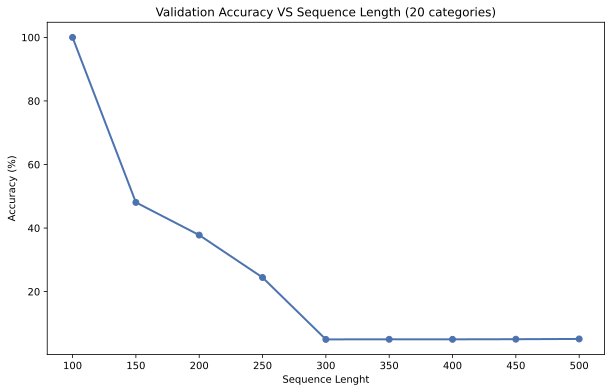

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, val_accs, '-ob')
plt.xticks(seq_lengths)
plt.title(f"Validation Accuracy VS Sequence Length ({nCategories} categories)")
plt.xlabel("Sequence Lenght")
plt.ylabel("Accuracy (%)")
plt.savefig("valaccs_20cat")
plt.show()

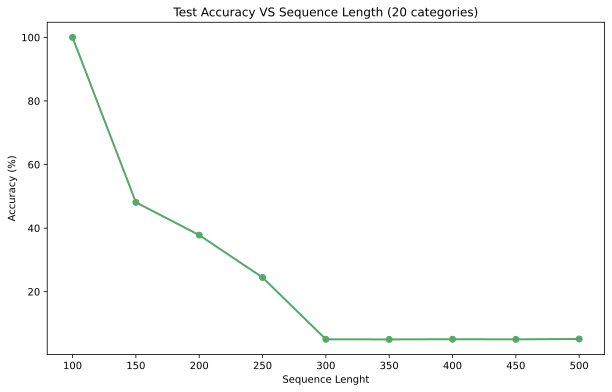

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, test_accs, '-og')
plt.xticks(seq_lengths)
plt.title(f"Test Accuracy VS Sequence Length ({nCategories} categories)")
plt.xlabel("Sequence Lenght")
plt.ylabel("Accuracy (%)")
plt.savefig("testaccs_20cat.png")
plt.show()